In [ ]:
# Preamble
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as so

%matplotlib inline

# Lab Maximum Likelihood Example - Laplace Distribution

In this lab, we will implement and solve a regression using the [Laplace Distribution](https://en.wikipedia.org/wiki/Laplace_distribution). The distribution has the following density and shape:

$$
f(x|\mu, b) = \frac{1}{2b} \exp\bigg(-\frac{|x-\mu|}{b}\bigg)
$$

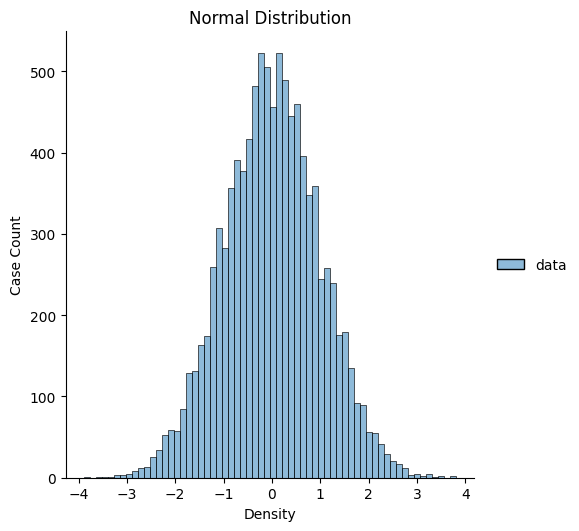

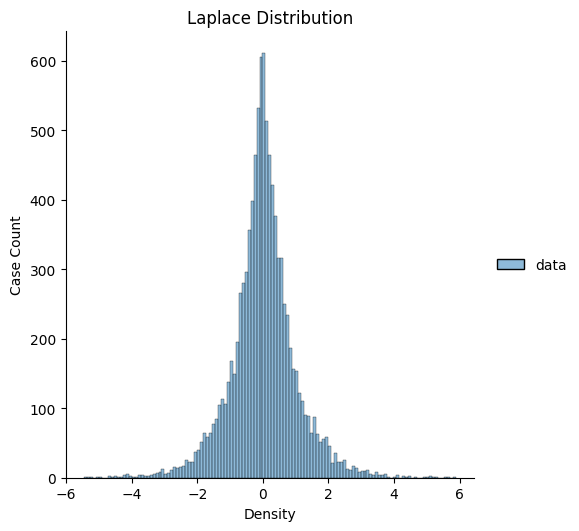

In [ ]:
# Generate data from a standard normal and a standard laplace distribution with b=1/sqrt(2)
n = 10001
normalData = pd.DataFrame({"data": pd.Series(np.random.normal(0,1,n))})
laplaceData = pd.DataFrame({"data": pd.Series(np.random.laplace(0,1/np.sqrt(2),n))})

# Plot a normal for comparison
sns.displot(normalData)
plt.title("Normal Distribution")
plt.xlabel("Density")
plt.ylabel("Case Count")

# Plot a laplace distribution
sns.displot(laplaceData)
plt.title("Laplace Distribution")
plt.xlabel("Density")
plt.ylabel("Case Count")

# Display the plots
plt.show()

Now we can calculate the log likelihood. The negative log-likelihood function is equal to:

$$
negll(y) = -\sum_i [-\log(2b) - \frac{|y_i - \mu|}{b}]
$$

$$
negll(y) = I \log(2b) + \sum_i \frac{|y_i - \mu|}{b}
$$

In [ ]:
## Laplace Negative Log Likelihood
def laplaceNegLogLikelihood(params, y):
    # Set the parameters
    mu = params[0]
    b = params[1]

    # Calculate the negative log likelihood
    neg_log_lik = -np.sum(-np.log(2*b) - abs(y - mu) / b)
    return neg_log_lik

To get the estimate, we can either maximize the log-likelihood or, as we do here, minimize the negative log-likelihood. We must set b to be positive, so we can add a [Linear Constraint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.LinearConstraint.html#scipy.optimize.LinearConstraint) to the minimization function and a solver that allows for constraints, such as the Sequential Least Squares Quadratic Programming ([SLSQP](https://mdolab-pyoptsparse.readthedocs-hosted.com/en/latest/optimizers/SLSQP.html)) algorithm.

In [ ]:
## Laplace Maximum Likelihood Estimate for mu and b.
def maximumLikelihood(y):
    # Define the linear constraint for b > 0. The equation is [0, 1] @ [mu, b].T >= 0
    b_constraint = so.LinearConstraint([[0, 1]], [0.01], [np.inf])

    # Optimize the negative log likelihood
    # [1, 1.5] is the first guess
    RES = so.minimize(laplaceNegLogLikelihood, [1, 1.5], args=(y), method="SLSQP",
                       tol = 1e-8, constraints=b_constraint)
    print(RES)
    return RES.x

# Test the function
maximumLikelihood(laplaceData.values)

# The result array gives you the maximum likelihood of the mean and sd
# which is close to mean 0 and sd 1/sqrt(2)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 13471.325337001128
       x: [ 4.548e-03  7.074e-01]
     nit: 22
     jac: [ 1.414e+00  7.690e-03]
    nfev: 90
    njev: 22


array([0.0045478 , 0.70740719])

From the density, it is relatively easy to see that the $\mu$ parameter must be the median of the distribution. The b parameter is what we gave it at the start, $1/\sqrt(2)$. Let's verify this:

In [ ]:
# Should give same answer as median!
laplaceData.median()

,0
data,0.004548


## Implementing a Laplace regression

We can use the model to generate a regression model. In this model, we assume that the data follows a linear regression, but **the errors are Laplace distributed**.

$$
y_i = \beta^T \cdot x + \varepsilon_i \\
\varepsilon_i \sim \mathscr{L}(0,b)
$$

We can ignore the estimation of the b parameter (or calculate it from the output errors afterwards), for the purpose of the regression. This is because the log-likelihood is independent of the $\beta$ parameters.

In [ ]:
!gdown https://drive.google.com/uc?id=11tUui3WpiMo2tToaRkPPlSAECJSBgdyM

Downloading...
From: https://drive.google.com/uc?id=11tUui3WpiMo2tToaRkPPlSAECJSBgdyM
To: /content/runningSpeeds.csv
100% 937/937 [00:00<00:00, 2.70MB/s]


In [ ]:
# Laplace Negative Log Likelihood for regression
def laplaceRegNegLogLikelihood(beta, X, y):
    # Calculate the mean of the response variable
    mu = (X@beta).reshape(-1,1)
    return laplaceNegLogLikelihood([mu, 1], y)


Let's load the data. It corresponds to running speeds per km for a marathon. Note the first column is the index, which we give to Pandas.

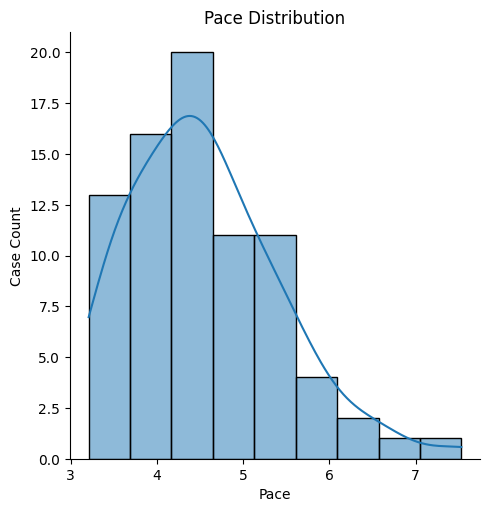

In [ ]:
run_data = pd.read_csv("runningSpeeds.csv", index_col=0)
run_data.head()

# Plot the pace distribution
sns.displot(run_data["pace"], kde=True)
plt.title("Pace Distribution")
plt.xlabel("Pace")
plt.ylabel("Case Count")
plt.show()

Now, let's minimize the function!

In [12]:
# Function to maximize regression log likelihood
def maximumRegLikelihood(X, y, negloglik=laplaceRegNegLogLikelihood):
    nrows,ncols = X.shape

    # Define the linear constraint for b > 0. The equation is [1, 0, ..., 0] @ [b, betas].T >= 0
    b_constraint = so.LinearConstraint(np.hstack(([1], np.zeros(ncols-1))), [0.01], [np.inf])

    # Optimize the negative log likelihood. Start with all zeros for the betas.
    betas=np.zeros((ncols,1)).reshape(-1)
    RES = so.minimize(negloglik, betas, args=(X,y), method="SLSQP", tol=1e-8, constraints=b_constraint)
    print(RES)
    return RES.x

age = run_data.age.values
# Add a column of ones to the age data for the intercept
X = np.c_[np.ones(age.size), age]
y = run_data.pace.values.reshape(-1,1)

# Run the function
betas = maximumRegLikelihood(X,y)

# Print the results
print(betas)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 100.7212613334175
       x: [ 3.335e+00  3.435e-02]
     nit: 29
     jac: [-1.000e+00  4.621e+01]
    nfev: 206
    njev: 29
[3.33514564 0.03434915]


We have our function. Let's calculate the goodness of fit.

Text(0.5, 1.0, 'Scatterplot Pace vs Laplace Prediction, R^2: 0.17')

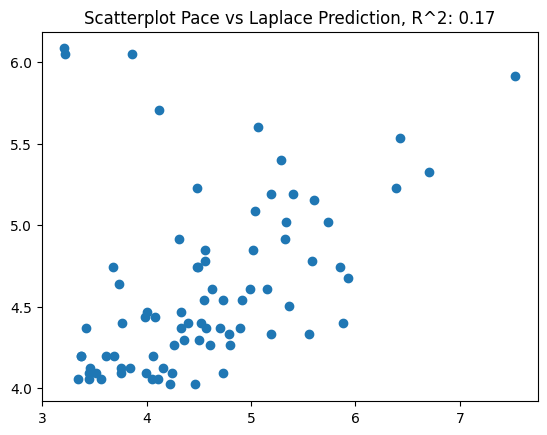

In [13]:
# Apply the betas to the data
y_pred = X @ betas

# Plot the scatter plot of the prediction and the actual data
plt.scatter(run_data.pace.values, y_pred)

# Add the R^2 value to the plot
R2 = np.corrcoef(run_data.pace.values, y_pred.flatten())[0,1]**2
plt.title(f"Scatterplot Pace vs Laplace Prediction, R^2: {R2:.2f}")

The regression is not great, but it satisfies our requirements. Let's plot the residuals.

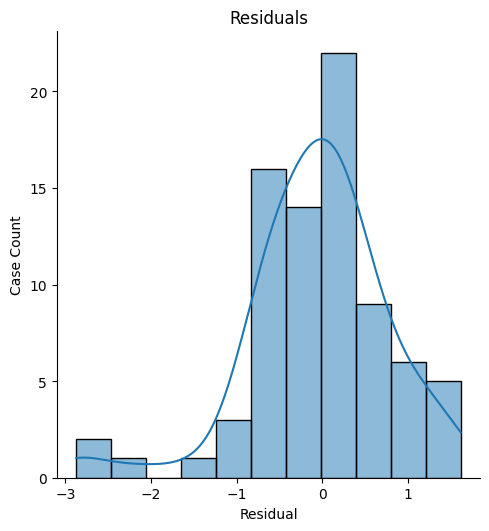

In [14]:
# Calculate the residuals
residuals = run_data.pace.values - y_pred.flatten()

# Plot the residuals
sns.displot(residuals, kde=True)
plt.title("Residuals")
plt.xlabel("Residual")
plt.ylabel("Case Count")
plt.show()


Again, the regression is not perfect, but the residuals are closer to what we expect. You can use this now to estimate any function and any parameters you want.